<a href="https://colab.research.google.com/github/nahumsa/deep-art/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer

We will reproduce the [paper](https://arxiv.org/abs/1508.06576) based on the implementation made by [keras.io](https://keras.io/examples/generative/neural_style_transfer/).

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from IPython.display import Image, display

Let's get the images that we want to use.

In [ ]:
base_image_path = keras.utils.get_file(
    "paris.jpg","https://i.imgur.com/F28w3Ac.jpg"
)

style_reference_image_path = keras.utils.get_file(
    "the_scream.jpg", "https://i.imgur.com/UWIRzW9.jpeg"
)

result_prefix = "paris_generated"

# Dimensions of the generated picture
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

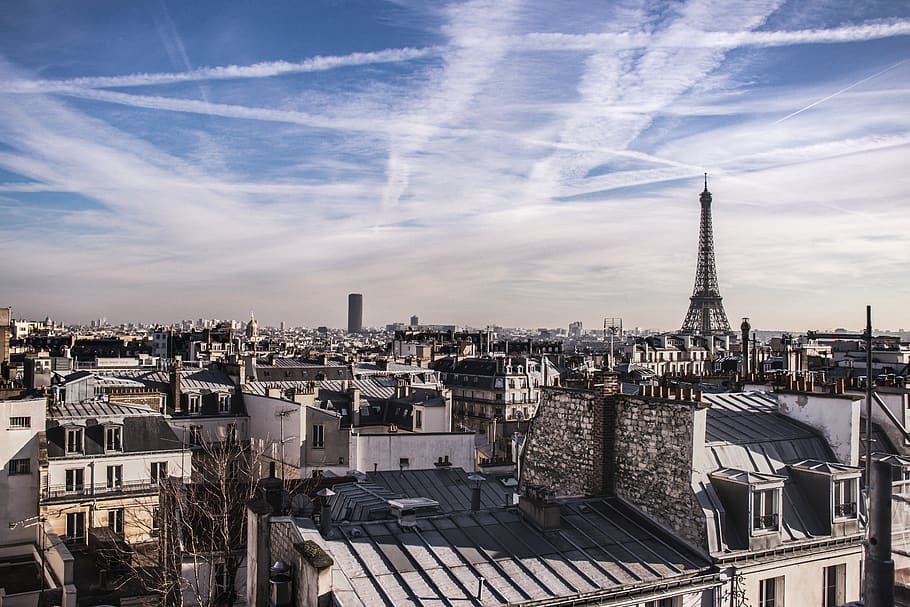

In [ ]:
display(Image(base_image_path))

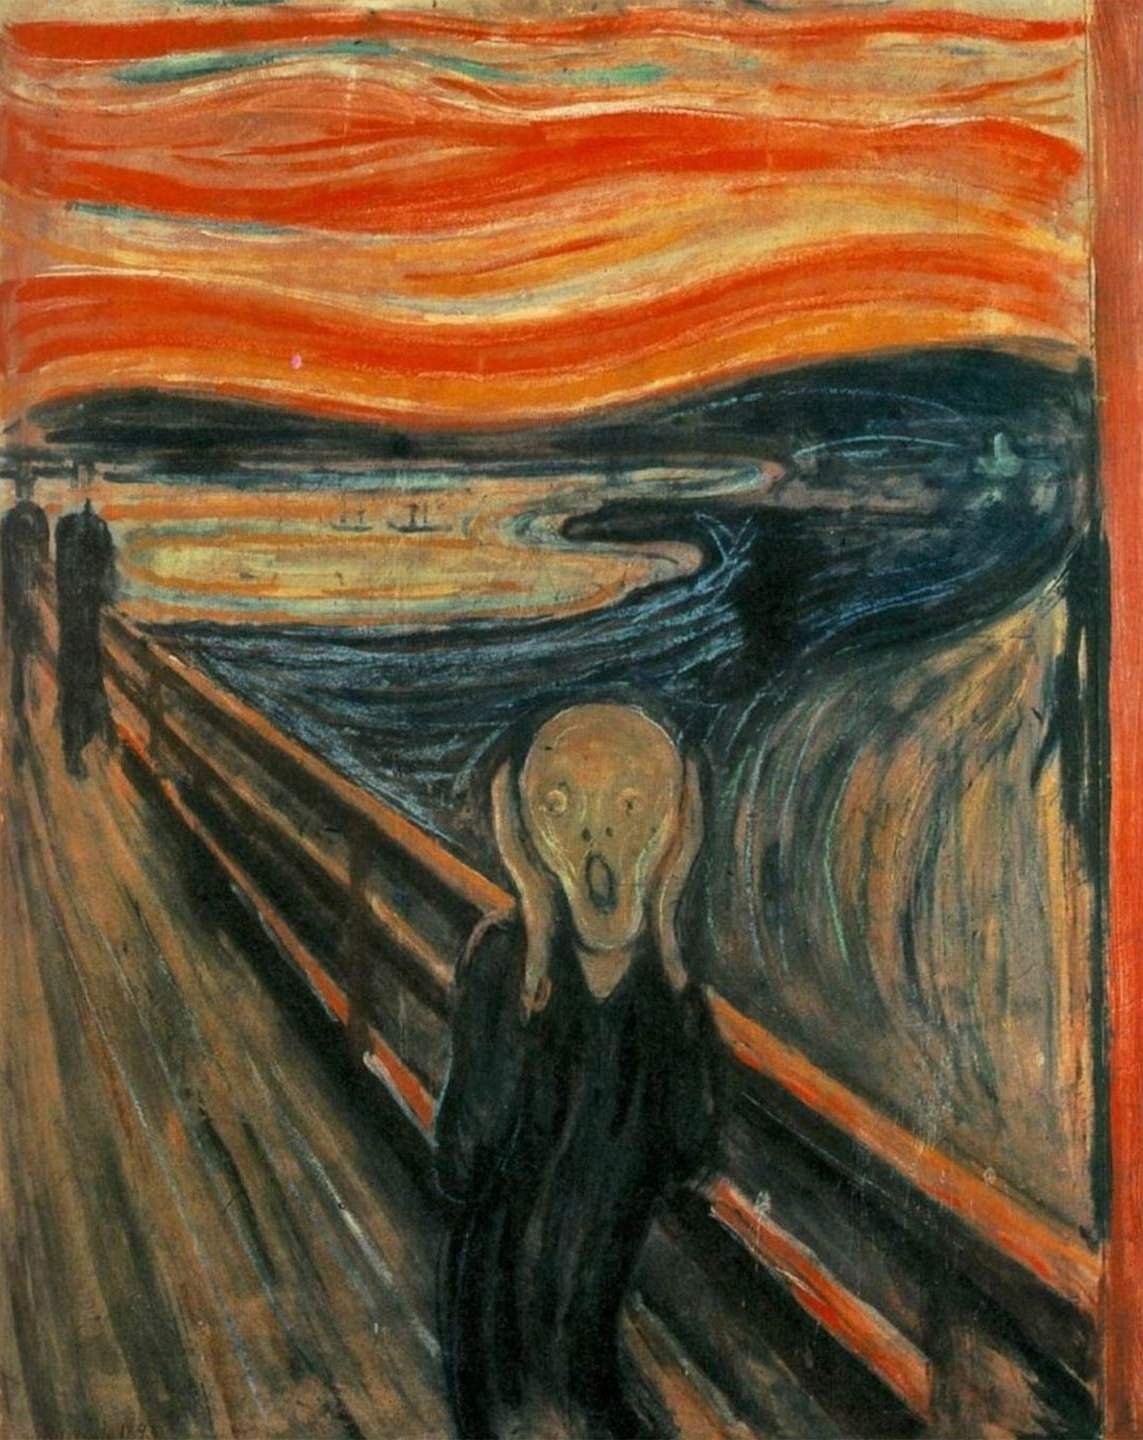

In [ ]:
display(Image(style_reference_image_path))

In [ ]:
def preprocess_image(image_path: str):
    """ Open, resize and format pictures into tensors for the VGG19.
    """
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_image(x: tf.Tensor):
    """ Convert from VGG output tensor to an image.
    """
    x = x.reshape((img_nrows, img_ncols, 3))
    
    # Remove zero-center by mean pixel this comes from the imagenet dataset
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # BGR -> RGB
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

 We will a [VGG-Network](https://arxiv.org/abs/1409.1556) as a basis and we will focus on the convolutional layers of the Neural Network (NN).

In [ ]:
from tensorflow.keras.applications import vgg19

# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80150528/80134624 [==============================] - 1s 0us/step


Each layer defines a non-linear filter whose complexity increases with the position of the layer in the network.

A layer with $N_l$ filters has $N_l$ filter meaps each of size $M_l$, where $M_l$ is the height times the width of each feature map.

We can encode the responses of a layer in a matrix $F^l \in \mathbb{R}^{N_l \times M_l}$, this representation encodes the activation of the ith layer at jth position in a layer l, which is represented as $F^l_{ij}$. This responses will be what encodes the content of the image that will be the input, thus representing the content part of the loss function.

So let $\vec{p}$ and $\vec{x}$ be the original image and the image that is generated respectively, and $P^l$ and $F^l$ their respective representation on layer $l$. We define the content loss as, $\mathcal{L}_{\mathrm{content}}$:

$$
\mathcal{L}_{\mathrm{content}}(\vec{p}, \vec{x}, l) = \frac{1}{2} \sum_{ij} \bigg( F_{ij}^l - P^l_{ij} \bigg)^2
$$

Thus, we can change the initially random image $\vec{x}$ until it generates the same response in a certain layer of the CNN as the original image $\vec{p}$. 

In [ ]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

With this we have a way to generate the original image, however we want to generate an image that has a particular style, this is done by adding another loss function that computes the correlations of each filter of each Convolutional Layer  with the expectation that is taken over th spatial extend of the input image.

We can get this feature correlations by using the Gram Matrix $G^l \in \mathbb{R}^{N_l \times N_l}$, which is given by the inner product of $F^l_{ij}$:

$$
G_{ij}^l = \sum_k F_{ik}^l F_{jk}^l
$$

TO generate the texture that matches the style, we can use gradient descend from a white noise image. This is done by minimizing the mean-square distance between the Gram Matrix of the input image and the style image:

$$
E_l = \frac{1}{4 N_l^2 M_l^2} \sum_{ij} \bigg(G_{ij}^l - A_{ij}^l \bigg)^2
$$

Thus, we have the total loss:

$$
\mathcal{L}_{\mathrm{style}} (\vec{a}, \vec{x}) = \sum_{l=0}^L w_l E_l
$$

Where $w_l$ are weighting factors for each layer.

In [ ]:
def gram_matrix(x: tf.Tensor):
    """ Construct the gram matrix for a tensor.
    """
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style: tf.Tensor, combination: tf.Tensor):
    """ 
    """
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

To generate an image which mix content of the photograph and style of a painting we must minimize the following loss function:

$$
\mathcal{L}_{\mathrm{total}} (\vec{p}, \vec{a}, \vec{x}) = \alpha \mathcal{L}_{\mathrm{content}} + \beta \mathcal{L}_{\mathrm{style}}
$$

$\alpha$ and $\beta$ are weighting factors.

The ratio $\alpha / \beta $ should be $10^{-3}$ or $10^{-4}$.

In [ ]:
from dataclasses import dataclass

# Hyperparameters
@dataclass
class Config:
    TOTAL_VARIATION_WEIGHT: float = 1e-6
    STYLE_WEIGHT: float = 1e-4
    CONTENT_WEIGHT: float = 2.5e-7

config = Config()

In [ ]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [ ]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + config.CONTENT_WEIGHT * content_loss(
        base_image_features, combination_features
    )

    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (config.STYLE_WEIGHT / len(style_layer_names)) * sl

    # Add total variation loss
    loss += config.TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)
    return loss

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

Let's train our model

In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 2000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss}")
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + f"_at_iteration_{i}.png"
        keras.preprocessing.image.save_img(fname, img)

In [ ]:
display(Image(result_prefix + f"_at_iteration_{iterations}.png"))